In [61]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow import keras 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [62]:
df = pd.read_csv(r"F:\College\SEM 8\Project Phase 2\Dataset\NCA Preprocessed\master_features_nca.csv")
df

,filename,cell_id,temp,charge_rate,discharge_rate,cycle,SOH,IC_bin_1,IC_bin_2,IC_bin_3,IC_bin_4,IC_bin_5,IC_bin_6,IC_bin_7,IC_bin_8,IC_bin_9,IC_bin_10,IC_bin_11,IC_bin_12,IC_bin_13,IC_bin_14,IC_bin_15,IC_bin_16,IC_bin_17,IC_bin_18,IC_bin_19,IC_bin_20
0,CY25-025_1-#1.csv,1,25,0.25,1.0,1,99.96,3.206253,3.435524,3.772510,4.192327,4.376286,4.411252,4.395339,4.414303,4.355476,4.333661,4.255246,4.207070,4.229390,4.248806,4.264151,4.198406,4.058616,3.920543,3.792856,3.647914
1,CY25-025_1-#1.csv,1,25,0.25,1.0,2,99.98,3.185611,3.409977,3.737496,4.066281,4.266975,4.396090,4.446812,4.448179,4.360321,4.327729,4.249921,4.223132,4.181276,4.225006,4.231327,4.158785,4.055173,3.905594,3.737473,3.648392
2,CY25-025_1-#1.csv,1,25,0.25,1.0,3,100.00,3.166235,3.397673,3.713245,4.049932,4.278990,4.421365,4.450810,4.431817,4.391418,4.318430,4.235653,4.189766,4.140167,4.167926,4.180849,4.145106,4.015124,3.896722,3.756668,3.646670
3,CY25-025_1-#1.csv,1,25,0.25,1.0,4,99.97,3.139468,3.376350,3.683448,4.050734,4.300114,4.407995,4.436810,4.450410,4.412355,4.307581,4.254307,4.162355,4.134256,4.143371,4.135573,4.118733,4.023064,3.867330,3.752034,3.631178
4,CY25-025_1-#1.csv,1,25,0.25,1.0,5,99.93,3.132129,3.346752,3.653736,4.027798,4.299433,4.435545,4.452270,4.429507,4.386280,4.314699,4.216513,4.164974,4.094929,4.101335,4.135343,4.100581,4.008745,3.881142,3.761407,3.626212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22639,CY45-05_1-#9.csv,9,45,0.50,1.0,411,84.65,2.514883,2.565545,2.627766,2.699047,2.773160,2.843176,2.911006,2.983123,3.064441,3.149434,3.248165,3.376864,3.545380,3.705835,3.774339,3.705556,3.564230,3.413748,3.287599,3.193869
22640,CY45-05_1-#9.csv,9,45,0.50,1.0,412,84.61,2.510205,2.560754,2.625429,2.698454,2.772929,2.842739,2.909885,2.981428,3.058461,3.143913,3.250500,3.392370,3.559592,3.706725,3.763518,3.694866,3.559024,3.417873,3.299083,3.207045
22641,CY45-05_1-#9.csv,9,45,0.50,1.0,413,84.60,2.513525,2.562124,2.623266,2.694897,2.769636,2.841089,2.910922,2.986128,3.067481,3.150786,3.245492,3.372555,3.540142,3.694258,3.752898,3.692722,3.562536,3.425323,3.303745,3.206924
22642,CY45-05_1-#9.csv,9,45,0.50,1.0,414,84.58,2.508238,2.557557,2.619624,2.690607,2.765388,2.838240,2.908339,2.980217,3.059386,3.144506,3.241048,3.372799,3.540815,3.700767,3.761809,3.701606,3.569719,3.425509,3.299934,3.202914


In [63]:
df_one_hot = pd.get_dummies(df, columns=['temp','charge_rate'])
df_one_hot

,filename,cell_id,discharge_rate,cycle,SOH,IC_bin_1,IC_bin_2,IC_bin_3,IC_bin_4,IC_bin_5,IC_bin_6,IC_bin_7,IC_bin_8,IC_bin_9,IC_bin_10,IC_bin_11,IC_bin_12,IC_bin_13,IC_bin_14,IC_bin_15,IC_bin_16,IC_bin_17,IC_bin_18,IC_bin_19,IC_bin_20,temp_25,temp_35,temp_45,charge_rate_0.25,charge_rate_0.5,charge_rate_1.0
0,CY25-025_1-#1.csv,1,1.0,1,99.96,3.206253,3.435524,3.772510,4.192327,4.376286,4.411252,4.395339,4.414303,4.355476,4.333661,4.255246,4.207070,4.229390,4.248806,4.264151,4.198406,4.058616,3.920543,3.792856,3.647914,True,False,False,True,False,False
1,CY25-025_1-#1.csv,1,1.0,2,99.98,3.185611,3.409977,3.737496,4.066281,4.266975,4.396090,4.446812,4.448179,4.360321,4.327729,4.249921,4.223132,4.181276,4.225006,4.231327,4.158785,4.055173,3.905594,3.737473,3.648392,True,False,False,True,False,False
2,CY25-025_1-#1.csv,1,1.0,3,100.00,3.166235,3.397673,3.713245,4.049932,4.278990,4.421365,4.450810,4.431817,4.391418,4.318430,4.235653,4.189766,4.140167,4.167926,4.180849,4.145106,4.015124,3.896722,3.756668,3.646670,True,False,False,True,False,False
3,CY25-025_1-#1.csv,1,1.0,4,99.97,3.139468,3.376350,3.683448,4.050734,4.300114,4.407995,4.436810,4.450410,4.412355,4.307581,4.254307,4.162355,4.134256,4.143371,4.135573,4.118733,4.023064,3.867330,3.752034,3.631178,True,False,False,True,False,False
4,CY25-025_1-#1.csv,1,1.0,5,99.93,3.132129,3.346752,3.653736,4.027798,4.299433,4.435545,4.452270,4.429507,4.386280,4.314699,4.216513,4.164974,4.094929,4.101335,4.135343,4.100581,4.008745,3.881142,3.761407,3.626212,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22639,CY45-05_1-#9.csv,9,1.0,411,84.65,2.514883,2.565545,2.627766,2.699047,2.773160,2.843176,2.911006,2.983123,3.064441,3.149434,3.248165,3.376864,3.545380,3.705835,3.774339,3.705556,3.564230,3.413748,3.287599,3.193869,False,False,True,False,True,False
22640,CY45-05_1-#9.csv,9,1.0,412,84.61,2.510205,2.560754,2.625429,2.698454,2.772929,2.842739,2.909885,2.981428,3.058461,3.143913,3.250500,3.392370,3.559592,3.706725,3.763518,3.694866,3.559024,3.417873,3.299083,3.207045,False,False,True,False,True,False
22641,CY45-05_1-#9.csv,9,1.0,413,84.60,2.513525,2.562124,2.623266,2.694897,2.769636,2.841089,2.910922,2.986128,3.067481,3.150786,3.245492,3.372555,3.540142,3.694258,3.752898,3.692722,3.562536,3.425323,3.303745,3.206924,False,False,True,False,True,False
22642,CY45-05_1-#9.csv,9,1.0,414,84.58,2.508238,2.557557,2.619624,2.690607,2.765388,2.838240,2.908339,2.980217,3.059386,3.144506,3.241048,3.372799,3.540815,3.700767,3.761809,3.701606,3.569719,3.425509,3.299934,3.202914,False,False,True,False,True,False


In [64]:
# -------------------------
# 1. One-hot encode temp & charge-rate
# -------------------------
# df_one_hot = pd.get_dummies(df, columns=['temp','charge_rate'])

# -------------------------
# 2. Drop useless columns
# -------------------------
df_dropped = df_one_hot.drop(columns=['filename', 'cell_id', 'discharge_rate'])

# -------------------------
# 3. Identify columns
# -------------------------
ic_cols = [col for col in df_dropped.columns if 'IC' in col]      # 20 IC bins
cycle_col = 'cycle'
one_hot_cols = [col for col in df_dropped.columns 
                if 'temp_' in col or 'charge_rate_' in col]

# Target
Y = df_dropped['SOH'].values

# Features before splitting
X_ic_all = df_dropped[ic_cols].values                # shape: (N, 20)
X_cycle_all = df_dropped[[cycle_col]].values         # shape: (N, 1)
X_onehot_all = df_dropped[one_hot_cols].values       # shape: (N, 6)

# -------------------------
# 4. Train/test split
# -------------------------
X_ic_train, X_ic_test, \
X_cycle_train, X_cycle_test, \
X_cat_train, X_cat_test, \
y_train, y_test = train_test_split(
    X_ic_all, X_cycle_all, X_onehot_all, Y,
    train_size=0.8, random_state=42
)

# -------------------------
# 5. Scale IC features
# -------------------------
ic_scaler = StandardScaler()
X_ic_train = ic_scaler.fit_transform(X_ic_train)
X_ic_test = ic_scaler.transform(X_ic_test)

# -------------------------
# 6. Scale cycle number
# -------------------------
cycle_scaler = StandardScaler()
X_cycle_train = cycle_scaler.fit_transform(X_cycle_train)
X_cycle_test = cycle_scaler.transform(X_cycle_test)

# -------------------------
# 7. Build final CONTEXT vector (cycle + one-hot)
# -------------------------
X_context_train = np.concatenate([X_cycle_train, X_cat_train], axis=1)
X_context_test = np.concatenate([X_cycle_test, X_cat_test], axis=1)

# -------------------------
# 8. Normalize SOH target
# -------------------------
y_mean = y_train.mean()
y_std = y_train.std()

y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

# -------------------------
# 9. Reshape IC features for CNN+LSTM (20 timesteps, 1 feature)
# -------------------------
X_ic_train = np.expand_dims(X_ic_train, axis=2)   # shape: (N, 20, 1)
X_ic_test  = np.expand_dims(X_ic_test, axis=2)

print("IC input:", X_ic_train.shape)
print("Context input:", X_context_train.shape)
print("Target:", y_train.shape)


IC input: (18115, 20, 1)
Context input: (18115, 7)
Target: (18115,)


__FGSM ATTACK__

In [65]:
def fgsm_attack(model, X_ic_test, X_context_test, y_test, epsilon = 0.05):
    X_ic_adv = tf.convert_to_tensor(X_ic_test)
    X_context_test = tf.convert_to_tensor(X_context_test)
    y_true = tf.convert_to_tensor(y_test)
    
    with tf.GradientTape() as tape:
        tape.watch(X_ic_adv)
        y_pred = model([X_ic_adv, X_context_test],training=False)
        loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)

    gradient = tape.gradient(loss, X_ic_adv)
    signed_grad = tf.sign(gradient)
    X_ic_adv = X_ic_adv + epsilon * signed_grad

    return X_ic_adv.numpy()


__Model Metrics__

In [66]:
from sklearn.metrics import mean_absolute_percentage_error

def attack_eval(model, X_ic_test, X_context_test, y_test, epsilon, model_name=""):
    X_ic_test_adv = fgsm_attack(model, X_ic_test, X_context_test, y_test, epsilon)

    y_pred = model.predict([X_ic_test, X_context_test])
    y_pred_adv = model.predict([X_ic_test_adv, X_context_test])


    print("-----------------")
    print("Normal Condition")
    print("-----------------")
    print("R2 Score:", r2_score(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

    print("-------------")
    print("Attacked Data")
    print("-------------")
    print("R2 Score:", r2_score(y_test, y_pred_adv))
    print("MAE:", mean_absolute_error(y_test, y_pred_adv))
    print("MSE:", mean_squared_error(y_test, y_pred_adv))
    print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_adv))

    print("-----")
    print("Plots")
    print("-----")

    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.scatter(y_test, y_pred, alpha = 0.5)
    plt.title(model_name+" Clean Data Predictions")
    min_val = min(min(y_test), min(y_pred))
    max_val = min(max(y_test), max(y_pred))
    plt.plot([min_val,max_val],[min_val,max_val], "r--")
    plt.xlabel("True SOH")
    plt.ylabel("Predicted SOH")
    plt.grid()

    plt.subplot(1,2,2)
    plt.scatter(y_test, y_pred_adv, alpha=0.5, color="orange")
    plt.title(model_name+" Attacked Data Predicitions")
    plt.plot([min_val,max_val],[min_val,max_val], "r--")
    plt.xlabel("True SOH")
    plt.ylabel("Predicted SOH")
    plt.grid()
    plt.show()



__CNN + LSTM__

----------
CNN + LSTM
----------
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
-----------------
Normal Condition
-----------------
R2 Score: 0.9969009680090222
MAE: 0.04071444466075712
MSE: 0.003060703844798673
MAPE: 0.2852135761887904
-------------
Attacked Data
-------------
R2 Score: 0.8687813478849183
MAE: 0.3457760895457315
MSE: 0.1295957686810499
MAPE: 2.3899097943447134
-----
Plots
-----


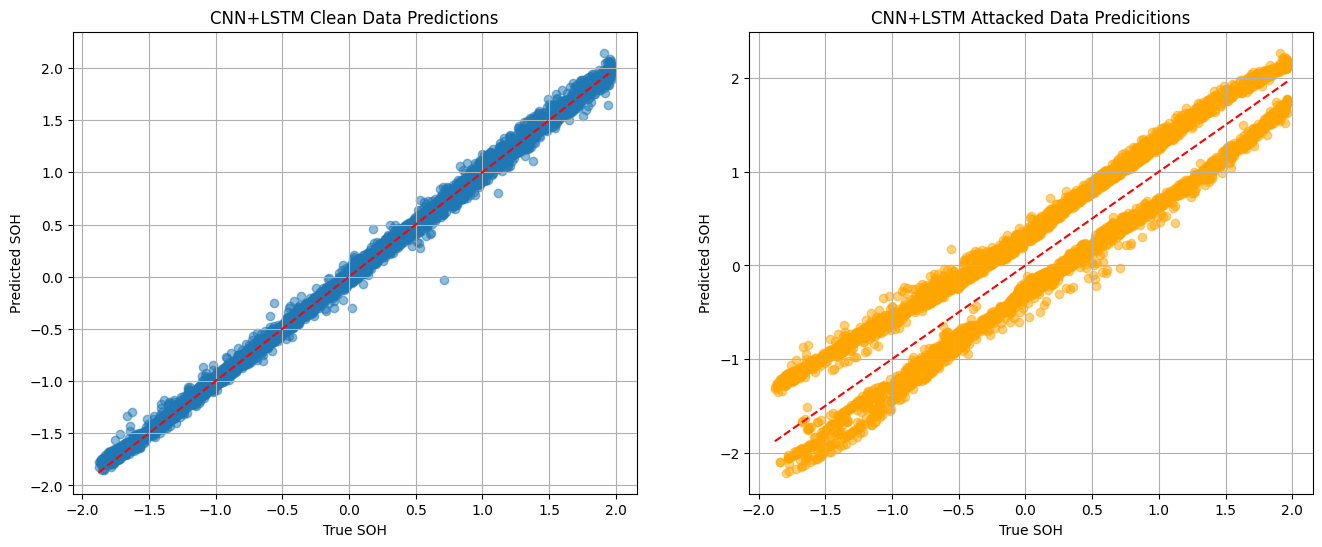

In [67]:
print("----------")
print("CNN + LSTM")
print("----------")
cnn_lstm = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Models\best_cnn_lstm.keras")

attack_eval(cnn_lstm, X_ic_test, X_context_test, y_test, epsilon=0.05, model_name="CNN+LSTM")

__CNN + GRU__

CNN + GRU
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
-----------------
Normal Condition
-----------------
R2 Score: 0.9973091788747214
MAE: 0.037599143584128074
MSE: 0.0026575416413198087
MAPE: 0.2821379877962994
-------------
Attacked Data
-------------
R2 Score: 0.8793880723542159
MAE: 0.3302648519845935
MSE: 0.11912022584754199
MAPE: 2.2923666855033265
-----
Plots
-----


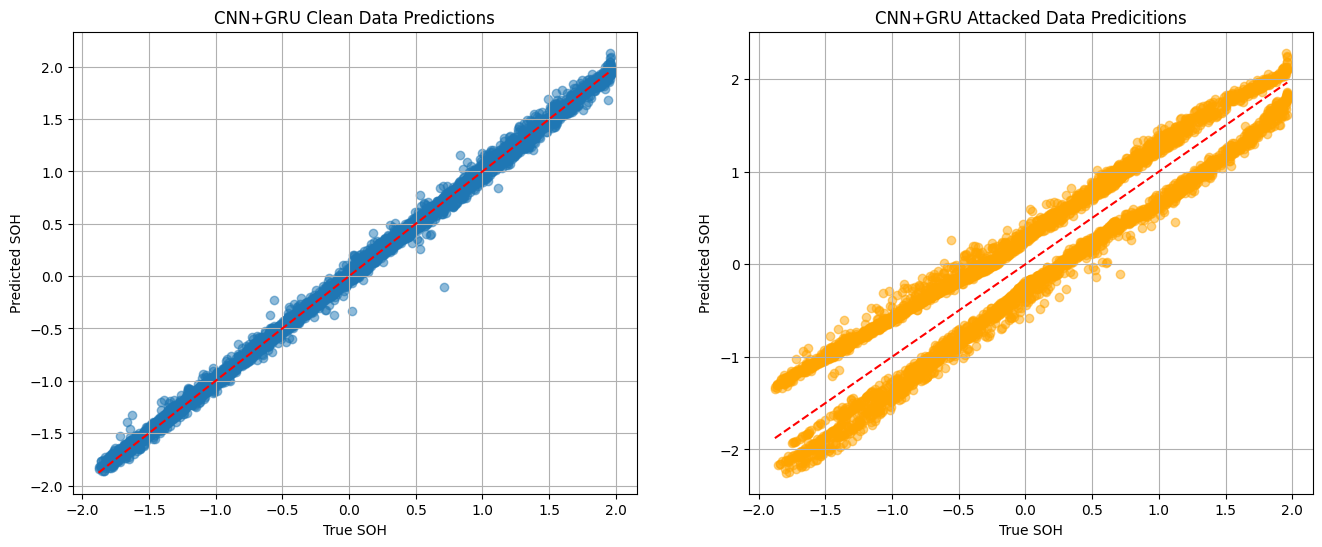

In [68]:
print("CNN + GRU")
cnn_gru = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Models\best_cnn_gru.keras")

attack_eval(cnn_gru, X_ic_test, X_context_test, y_test, epsilon=0.05, model_name="CNN+GRU")

__RCN__

---
RCN
---
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
-----------------
Normal Condition
-----------------
R2 Score: 0.9963593762223153
MAE: 0.04451132274039512
MSE: 0.0035955973433850785
MAPE: 0.47440765388510436
-------------
Attacked Data
-------------
R2 Score: 0.9126417450564019
MAE: 0.2819665092298269
MSE: 0.08627782725676626
MAPE: 2.3570056280495373
-----
Plots
-----


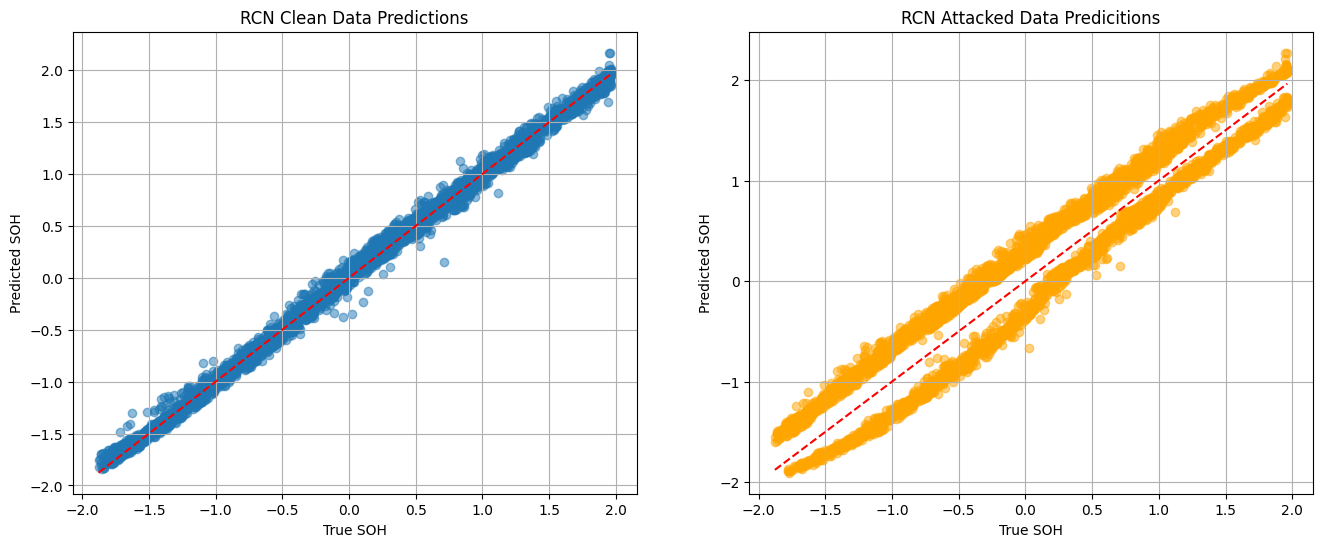

In [70]:
print("---")
print("RCN")
print("---")

rcn = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Models\best_rcn.keras")

attack_eval(rcn, X_ic_test, X_context_test, y_test, epsilon = 0.05, model_name="RCN")

__CNN__

---
CNN
---
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
-----------------
Normal Condition
-----------------
R2 Score: 0.9848092259048676
MAE: 0.09442292512359997
MSE: 0.015002897941615016
MAPE: 0.5742935546369837
-------------
Attacked Data
-------------
R2 Score: 0.8822472630529645
MAE: 0.2847208269336407
MSE: 0.11629639699061185
MAPE: 4.003818845399319
-----
Plots
-----


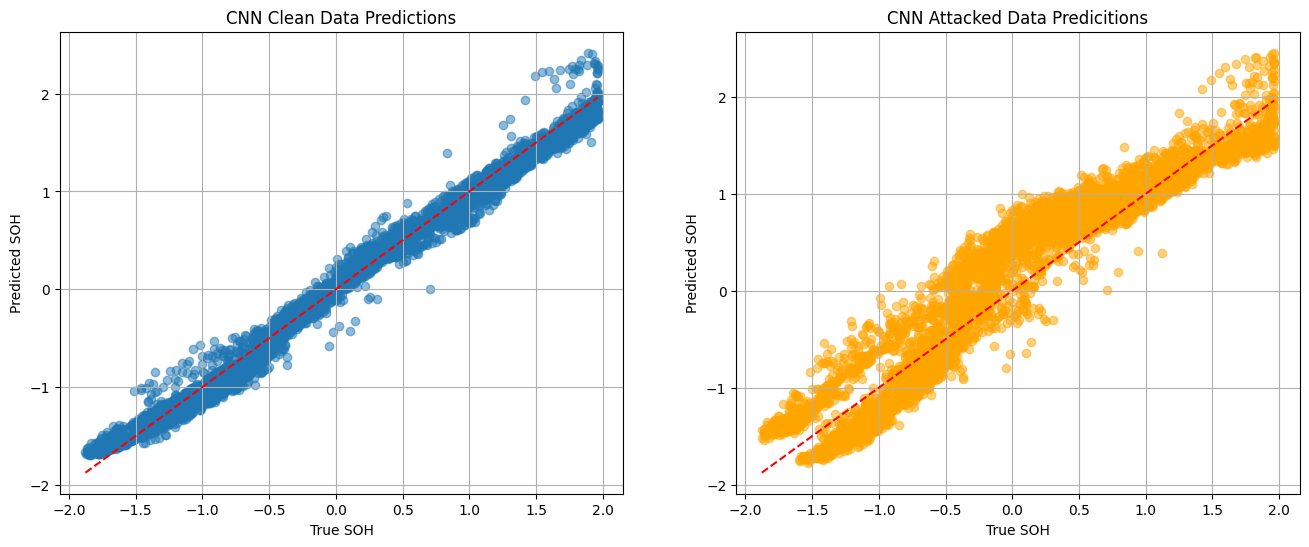

In [71]:
print("---")
print("CNN")
print("---")

cnn = keras.models.load_model(r"F:\College\SEM 8\Project Phase 2\Models\best_cnn.keras")

attack_eval(cnn, X_ic_test, X_context_test, y_test, epsilon = 0.05, model_name="CNN")

In [72]:
idx = 100   

orig_ic = X_ic_test[idx].reshape(-1)     
orig_ctx = X_context_test[idx].reshape(1,-1)
orig_true = y_test[idx]

adv_ic = fgsm_attack(
    cnn_gru,
    X_ic_test[idx:idx+1],     
    X_context_test[idx:idx+1],
    y_test[idx:idx+1]
)

adv_ic = adv_ic.reshape(-1)

y_pred_orig = cnn_gru.predict([X_ic_test[idx:idx+1], X_context_test[idx:idx+1]])[0][0]
y_pred_adv  = cnn_gru.predict([adv_ic.reshape(1,-1,1), X_context_test[idx:idx+1]])[0][0]

y_pred_orig = y_pred_orig * y_std + y_mean
y_pred_adv = y_pred_adv * y_std + y_mean

orig_true = orig_true * y_std + y_mean

print("Original pred:", y_pred_orig)
print("Adversarial pred:", y_pred_adv)
print("True value:", orig_true)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Original pred: 85.74653687359482
Adversarial pred: 87.24539923308252
True value: 85.45


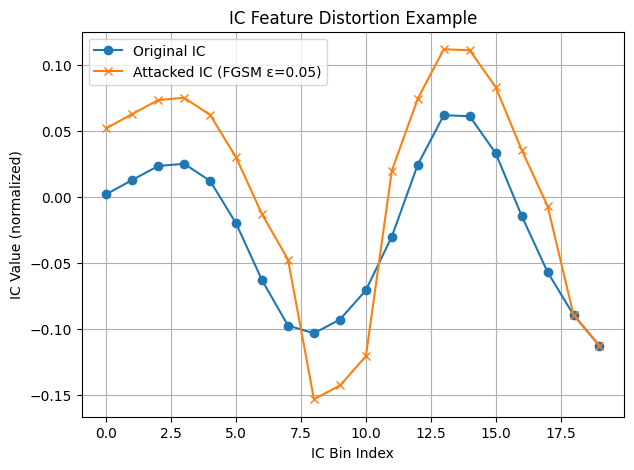

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(orig_ic, marker='o', label="Original IC")
plt.plot(adv_ic, marker='x', label="Attacked IC (FGSM ε=0.05)")
plt.title("IC Feature Distortion Example")
plt.xlabel("IC Bin Index")
plt.ylabel("IC Value (normalized)")
plt.legend()
plt.grid(True)
plt.show()
